This jupyter notebook fits a smaller pooled HMM (with 10 subjects only) and looks at the results per subject. This is a precursor to running a full script with all 84 subjects.

In [8]:
import numpy as np
import pandas as pd
import json
from hmmlearn import hmm
import matplotlib.pyplot as plt
import seaborn as sns
import arviz
import pickle
from scipy import stats
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [9]:
print("Loading data...")
with open("../cleaned_data_files/subject_data_for_HMM.json", "r") as f:
    subject_data = json.load(f)
    
print(f"Loaded {len(subject_data)} subjects")

Loading data...
Loaded 84 subjects


In [12]:
# Test with first few subjects
test_subjects = list(subject_data.keys())[:5]

Fit individual subjects first:

In [16]:
for subject_id in test_subjects:
    print(f"\n--- Subject {subject_id} ---")
    
    subj = subject_data[subject_id]
    
    # Prepare observations
    accuracy = np.array(subj['epoch_accuracy'])
    rest_duration = np.array(subj['post_epoch_post_cue_rest_duration'])
    # rest_follows_switch_cue = np.array(subj['rest_cue_type']) # 1 is switch 0 is stay
    # acc_follows_switch = np.array(subj['epoch_follows_task_switch']) # 1 is switch 0 is stay
    # overall_epoch = np.array(subj['overall_epoch']) # 1 to 30
    # game_type = np.array(subj['game_type']) # spatial_recall or digit_span
    
    # create observation array
    obs = np.column_stack([accuracy, rest_duration])
    
    print(f"Observation data shape: {obs.shape}")
    print(f"Accuracy range: {accuracy.min():.3f} to {accuracy.max():.3f}")
    print(f"Rest range: {rest_duration.min():.3f} to {rest_duration.max():.3f} trials")

    # PER SUBJECT: fit 10 different models (with 10 different random initializations) and pick the best ones
    # also try different states (from 1 to 3)
    scores = list()
    models = list()
    for n_components in range(1, 3):
        for idx in range(10):  # ten different random starting states
            # define our hidden Markov model
            model = hmm.GaussianHMM(n_components=n_components, covariance_type="full", 
                               n_iter=50, random_state=idx)
            model.fit(obs)
            models.append(model)
            scores.append(model.score(obs))
            print(f'Converged: {model.monitor_.converged}\t\t'
                  f'Score: {scores[-1]}')
    
    # get the best model
    model = models[np.argmax(scores)]
    print(f'The best model for subject {subject_id} had a score of {max(scores)} and '
          f'{model.n_components} components')

    # print results
    log_prob = model.score(obs)
    states = model.predict(obs)
    print(f"✓ Model fitted successfully!")
    print(f"  bed model log probability: {log_prob:.2f}")
    print(f"  Converged: {model.monitor_.converged}")

    # Show state characteristics
    print("\nState characteristics:")
    for i in range(model.n_components):
        mean_acc = model.means_[i, 0]
        mean_rest = model.means_[i, 1]
        state_count = np.sum(states == i)
        print(f"  State {i}: accuracy={mean_acc:.3f}, rest={mean_rest:.3f}s, count={state_count}")

    print(f"\nTransition matrix for subject {subject_id}:")
    for i, row in enumerate(model.transmat_):
        print(f"  From state {i}: {row}")

Model is not converging.  Current: -30.629933355565075 is not greater than -30.62966587766252. Delta is -0.00026747790255399195



--- Subject 4 ---
Observation data shape: (30, 2)
Accuracy range: 0.700 to 1.000
Rest range: 1.000 to 9.000 trials
Converged: True		Score: -43.63289495431464
Converged: True		Score: -43.63289495431464
Converged: True		Score: -43.63289495431464
Converged: True		Score: -43.63289495431464
Converged: True		Score: -43.63289495431464
Converged: True		Score: -43.63289495431464
Converged: True		Score: -43.63289495431464
Converged: True		Score: -43.63289495431464
Converged: True		Score: -43.63289495431464
Converged: True		Score: -43.63289495431464
Converged: True		Score: -19.342622699569024
Converged: True		Score: -19.335482969377583
Converged: True		Score: -18.406738186001096
Converged: True		Score: -30.63004812216988
Converged: True		Score: -19.33548784995976
Converged: True		Score: -18.406767676441593
Converged: True		Score: -18.406726272811557
Converged: True		Score: -19.336094088233025
Converged: True		Score: -19.33962817548624
Converged: True		Score: -40.71457518954646
The best model for

Pooled model with all test subjects:

Pooled data shape: (150, 2)
Subject lengths: [30, 30, 30, 30, 30]
Converged: True		Score: 9.702509819660758
Converged: True		Score: 9.702509819660758
Converged: True		Score: 9.702509819660758
Converged: True		Score: 9.702509819660758
Converged: True		Score: 9.702509819660758
Converged: True		Score: 9.702509819660758
Converged: True		Score: 9.702509819660758
Converged: True		Score: 9.702509819660758
Converged: True		Score: 9.702509819660758
Converged: True		Score: 9.702509819660758
Converged: True		Score: 9.702509819660758
Converged: True		Score: 9.702509819660758
Converged: True		Score: 9.702509819660758
Converged: True		Score: 9.702509819660758
Converged: True		Score: 9.702509819660758
Converged: True		Score: 9.702509819660758
Converged: True		Score: 9.702509819660758
Converged: True		Score: 9.702509819660758
Converged: True		Score: 9.702509819660758
Converged: True		Score: 9.702509819660758
The best model had a score of 9.702509819660758 and 2 components
✓ Pooled model fitted success

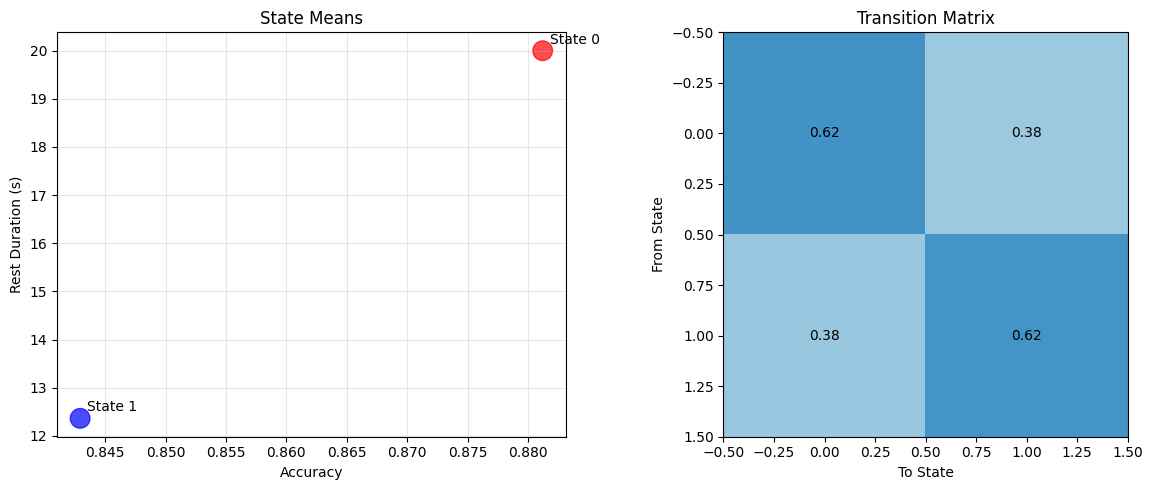

In [20]:
# Combine all subjects
all_obs = []
lengths = []

for subject_id in test_subjects:
    subj = subject_data[subject_id]
    accuracy = np.array(subj['epoch_accuracy'])
    rest_duration = np.array(subj['post_epoch_post_cue_rest_duration'])
    obs = np.column_stack([accuracy, rest_duration])
    all_obs.append(obs)
    lengths.append(len(obs))

pooled_obs = np.vstack(all_obs)
print(f"Pooled data shape: {pooled_obs.shape}")
print(f"Subject lengths: {lengths}")

scores = list()
models = list()
for n_components in range(1, 3):
    for idx in range(10):
        pooled_model = hmm.GaussianHMM(n_components=n_components, covariance_type="full",
                                      n_iter=50, random_state=idx)
        pooled_model.fit(pooled_obs, lengths=lengths)
        models.append(model)
        scores.append(model.score(obs))
        print(f'Converged: {model.monitor_.converged}\t\t'
              f'Score: {scores[-1]}')
        
# get the best model
pooled_model = models[np.argmax(scores)]
print(f'The best model had a score of {max(scores)} and '
      f'{pooled_model.n_components} components')

pooled_log_prob = pooled_model.score(pooled_obs, lengths=lengths)
print(f"✓ Pooled model fitted successfully!")
print(f"  Log probability: {pooled_log_prob:.2f}")
print(f"  Converged: {pooled_model.monitor_.converged}")

print(f"\nPooled state characteristics:")
for i in range(pooled_model.n_components):
    mean_acc = pooled_model.means_[i, 0]
    mean_rest = pooled_model.means_[i, 1]
    print(f"  State {i}: accuracy={mean_acc:.3f}, rest={mean_rest:.3f}s")

print(f"\nPooled transition matrix:")
for i, row in enumerate(pooled_model.transmat_):
    print(f"  From state {i}: {row}")

# Quick visualization
try:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot state means
    ax1.scatter(pooled_model.means_[:, 0], pooled_model.means_[:, 1], 
               s=200, alpha=0.7, c=['red', 'blue'])
    for i, mean in enumerate(pooled_model.means_):
        ax1.annotate(f'State {i}', (mean[0], mean[1]), 
                   xytext=(5, 5), textcoords='offset points')
    ax1.set_xlabel('Accuracy')
    ax1.set_ylabel('Rest Duration (s)')
    ax1.set_title('State Means')
    ax1.grid(True, alpha=0.3)
    
    # Plot transition matrix
    im = ax2.imshow(pooled_model.transmat_, cmap='Blues', vmin=0, vmax=1)
    ax2.set_title('Transition Matrix')
    ax2.set_xlabel('To State')
    ax2.set_ylabel('From State')
    for i in range(2):
        for j in range(2):
            ax2.text(j, i, f'{pooled_model.transmat_[i,j]:.2f}', 
                   ha='center', va='center')
    
    plt.tight_layout()
    plt.show()
    # plt.savefig('hmm_test_results.png', dpi=150, bbox_inches='tight')
    # print(f"\n Plot saved as 'hmm_test_results.png'")
    
except Exception as e:
    print(f"Plotting failed: {e}")